In [9]:
import diplib as dip
import matplotlib
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import string
from tqdm import trange


matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.ioff()
image_dir = 'images/'

# 5.1

In [10]:
def min_max_rescale(img):
    # rescale to 0..1
    return (img - np.min(img)) / (np.max(img) - np.min(img)) 


def segment_embryo(img):
    img_np = np.array(img)
    grayscale = 0.3 * img_np[:, :, 0] + 0.59 * img_np[:, :, 1] + 0.11 * img_np[:, :, 2]
    grayscale = dip.Image(grayscale)
    smoothed = dip.Gauss(grayscale, sigmas=[2.0])
    thresholded = dip.TriangleThreshold (smoothed)
    labeled = dip.Label(thresholded, connectivity=2)
    sizes = dip.MeasurementTool.Measure(labeled, features=['Size'])
    largest_label = np.argmax(sizes['Size']) + 1
    mask = labeled == largest_label
    
    return mask

def unify_images(images):
    unified_images = {}
    for key in images.keys():
        parsed_img = np.mean(images[key], axis=0)
        unified_images[key] = dip.Image(parsed_img)
    return unified_images


def convert_to_datastructure(images):
    output = []
    for img_name in images.keys():
        output.append((images[img_name], f'w8t1t2_d7_{img_name}.tif'))
    return output


def load_images(image_dir):
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    obj_pattern = r'(\d{2}).*\.tif'
    raw_images = {}
    
    for image_file in image_files:
        if 'flipped' in image_file: # discard this image
            continue
        object_name = re.search(obj_pattern, image_file).group(1)
        if object_name not in raw_images.keys():
            raw_images[object_name] = []
        img = dip.ImageReadTIFF(os.path.join(image_dir, image_file))
        img = min_max_rescale(img)
        raw_images[object_name].append(img)
    
    unified_images = unify_images(raw_images)
    return unified_images
        

def process_images(images):
    processed_images = {}
    for img_name in images.keys():
        mask = segment_embryo(images[img_name])
        processed_images[img_name] = mask
    return processed_images


def create_image_panel(images, suptitle):
    fig, axes = plt.subplots(4, 15, figsize=(28, 8))
    axes = axes.flatten()
    img_names = sorted(list(images.keys()))
    for ax, img_name in zip(axes, img_names):
        ax.imshow(images[img_name], cmap='gray')
        ax.set_title(f'w8t1t2_d7_{img_name}.tif')
    [ax.axis('off') for ax in axes]
    plt.suptitle(suptitle, fontsize=18, y=0.98)
    plt.tight_layout()
    # plt.savefig(f'figures/{suptitle.lower().replace(' ', '_')}.png')


def label_images(segmented_images):
    labeled_images = {}
    for img_name in segmented_images.keys():
        labeled_images[img_name] = dip.Label(segmented_images[img_name],
                                             connectivity=2)
    return labeled_images


In [11]:
# Load and process data
images_all = {'raw': {}, 'segmented': {}}
images_all['raw'] = load_images(image_dir)
images_all['segmented'] = process_images(images_all['raw'])
images_all['labeled'] = label_images(images_all['segmented'])

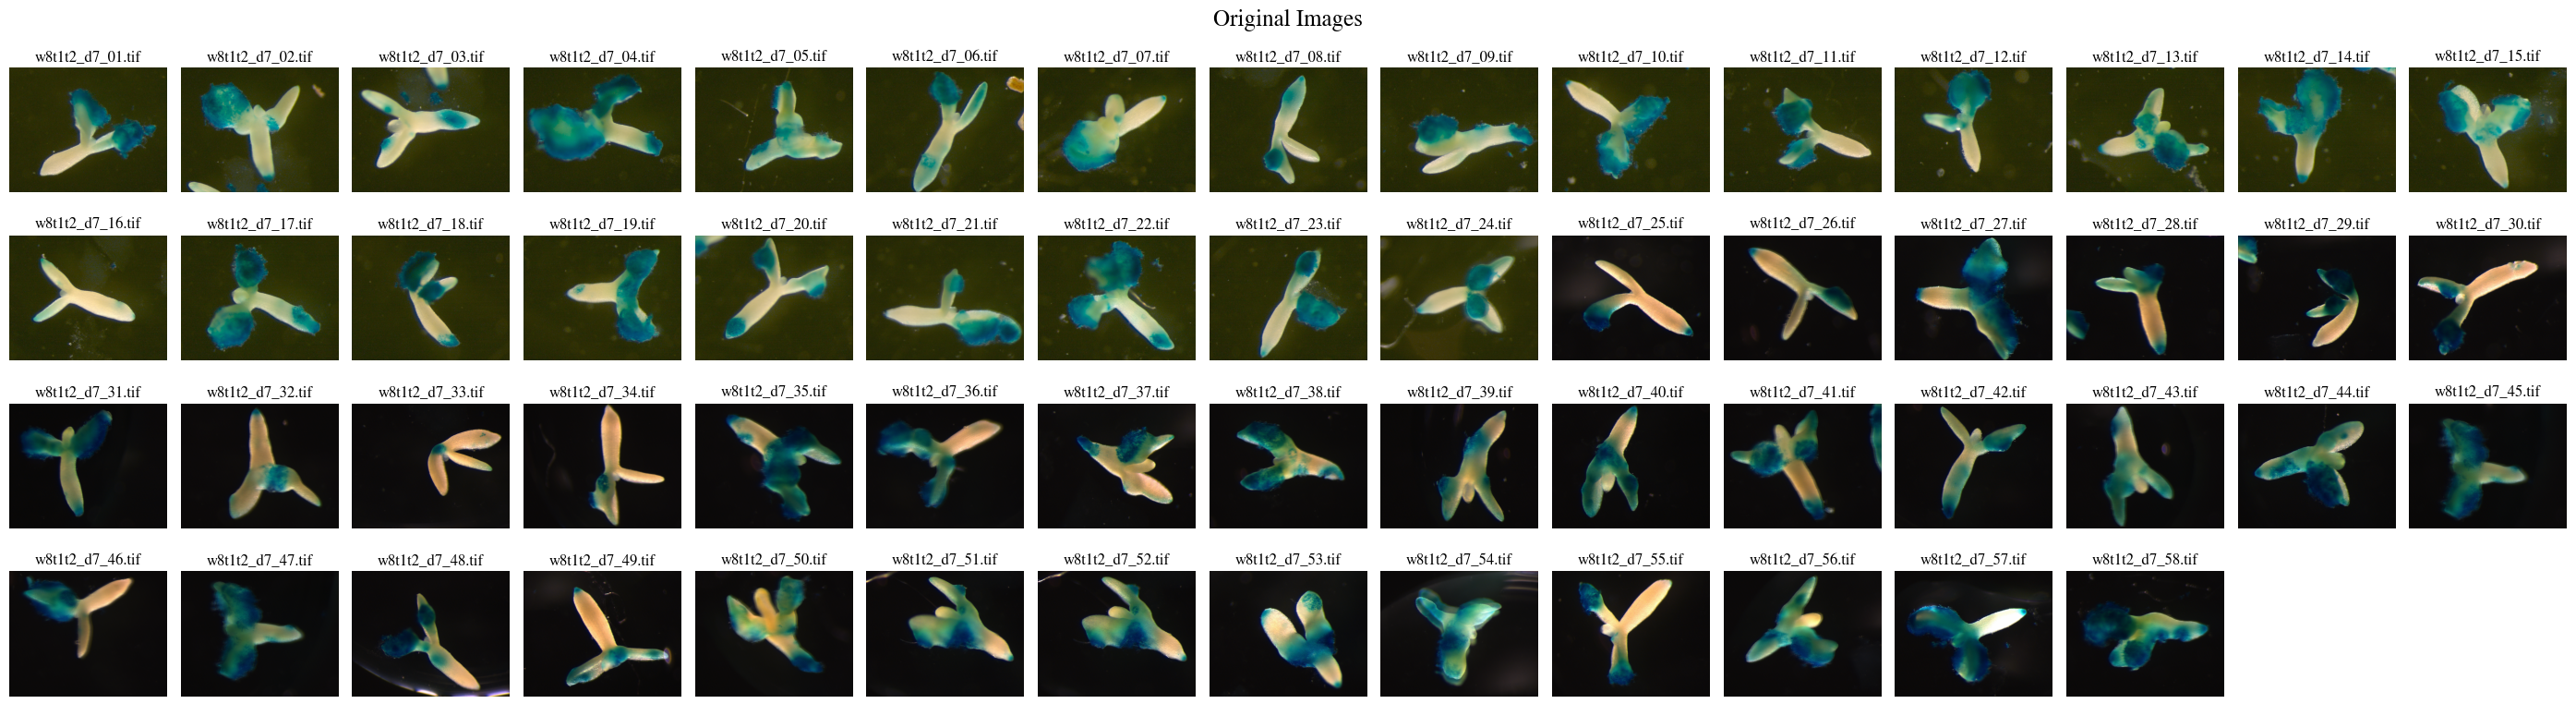

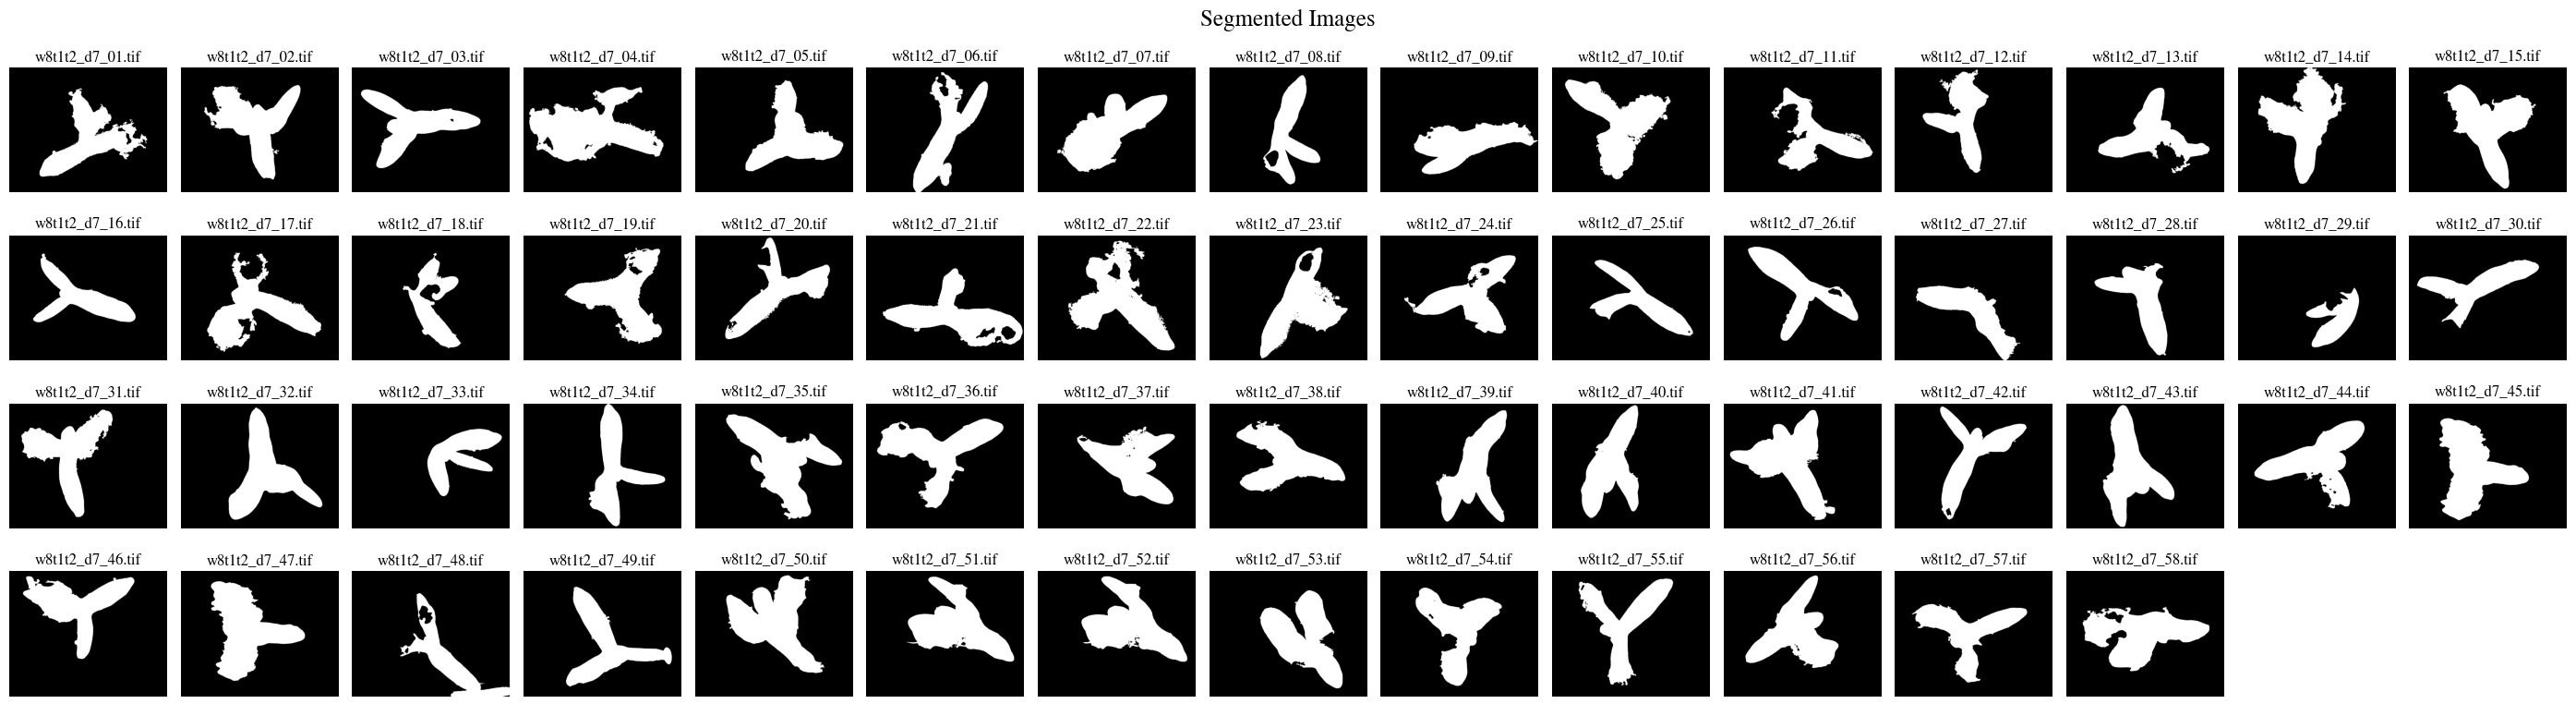

In [12]:
create_image_panel(images_all['raw'], 'Original Images')
create_image_panel(images_all['segmented'], 'Segmented Images')

# 5.2

In [13]:
def measure_features(img, mask, labeled):
    area = np.sum(mask)
    measurements = dip.MeasurementTool.Measure(labeled,
                                               features=['Perimeter', 'Size',
                                                         'Feret', 'Roundness'])
    # shape_features = measurements[labeled==1]  # Assuming single labeled object
    largest_label = np.argmax(measurements['Size']) + 1

    # print (measurements['Perimeter'][largest_label])
    # print(measurements)
    # print(img.TensorElement(0))
    
    # convert to HSV, then use saturation channel to find the blue
    hsv_img = dip.ColorSpaceManager.Convert(img, 'HSV')
    saturation_channel = hsv_img.TensorElement(1)
    
    # mask the saturation channel again, so most of the embryo is excluded
    blue_threshold = 0.7 
    blue_mask = saturation_channel > blue_threshold
    
    # use both blue mask and regular mask to only measure blue size
    absolute_blue = np.sum(saturation_channel[blue_mask & mask])
    relative_blue = absolute_blue / area
    
    # print(relative_blue)
    
    # fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # axes[0].imshow(np.array(img), cmap='gray')
    # axes[0].set_title('original')
    # axes[0].axis('off')
    
    # axes[1].imshow(np.array(blue_mask), cmap='gray')
    # axes[1].set_title('blue_mask')
    # axes[1].axis('off')
    
    # # Apply mask to saturation channel
    # masked_saturation = np.array(saturation_channel) * mask
    # axes[2].imshow(masked_saturation, cmap='gray')
    # axes[2].set_title('masked saturation')
    # axes[2].axis('off')
    
    # plt.tight_layout()
    # plt.show()

    return {
        'Area': area,
        'Perimeter': measurements['Perimeter'][largest_label],
        # 'Feret': measurements['Feret'][largest_label],
        'Roundness': measurements['Roundness'][largest_label],
        'absolute_blue': absolute_blue,
        'relative_blue': relative_blue
    }

def process_images(raw_images, segmented_images, labeled_images):
    all_features = []
    
    for img_name in raw_images.keys():
        features = measure_features(raw_images[img_name],
                                    segmented_images[img_name],
                                    labeled_images[img_name])
        features['Image'] = f'w8t1t2_d7_{img_name}.tif'
        all_features.append(features)
        # break
    
    return all_features


image_dir = 'images/'
all_features = process_images(images_all['raw'],
                              images_all['segmented'],
                              images_all['labeled'])
features_df = pd.DataFrame(all_features)


C:\Users\bramv\AppData\Local\Temp\ipykernel_6864\3036586629.py:15: DeprecationWarning: dip.Image.TensorElement() is deprecated and will be removed in a future version of PyDIP. Use () indexing instead.
  saturation_channel = hsv_img.TensorElement(1)


In [14]:
features_df.sort_values(by='Image')

Area             Perimeter              Roundness  absolute_blue  \
0   219893   [4843.584592653589]   [0.1198658349014418]   51657.175781   
1   246088  [3693.9715926535896]   [0.2274170379441088]   53491.968750   
2   212139  [3048.4145926535894]    [0.287421216352719]  102108.359375   
3   351637    [5010.90059265359]   [0.1788956028048353]   19406.957031   
4   230210  [3023.6455926535896]  [0.31647969113170166]   35179.796875   
5   222329    [4157.31659265359]  [0.16197652165921633]   26409.054688   
6   268204  [3301.9895926535896]   [0.3091671463957071]   65542.937500   
7   158754  [2685.3705926535895]   [0.2935417261961656]   36373.910156   
8   219557    [3145.28559265359]   [0.2793930724773571]   72148.859375   
9   286021   [4196.526592653589]   [0.2048342544715995]   42539.070312   
10  191811    [4214.71659265359]  [0.13700682116012117]   37215.535156   
11  176355    [3413.98159265359]   [0.1902777163317648]   28664.314453   
12  203407  [3628.0615926535893]  [0.19448958992711352]   27708.058594   
13  284312    [3899.11659265359]  [0.23775255384290184]    4043.967529   
14  262981    [3309.64259265359]  [0.30169773002047356]   56595.429688   
15  154957  [2708.0205926535896]   [0.2655321663619503]  105030.898438   
16  253995    [5637.71359265359]  [0.10052127185400413]   33367.500000   
17  136240    [3200.46159265359]  [0.16724033007184902]   24110.158203   
18  250946   [3926.612592653589]   [0.2099868512697383]   34768.921875   
19  203439  [3919.6705926535897]   [0.1667648505349313]   53431.042969   
20  261860   [3674.575592653589]  [0.25768377742737264]   59113.601562   
21  306184    [5187.19359265359]  [0.14728544128223986]   60580.218750   
22  249766    [3714.62259265359]  [0.23953423592570966]   35502.437500   
23  215691  [3683.2555926535897]   [0.2033897401822613]   43739.328125   
24  159305  [2886.4935926535895]  [0.24058591415150657]   41983.761719   
25  200978  [3098.1965926535895]  [0.26876088424949296]   10242.541016   
26  174242   [2666.100592653589]  [0.30808069095128354]   15484.822266   
27  175927  [2591.3725926535894]   [0.3292172922313514]    9584.923828   
28   97357  [2106.1515926535894]   [0.2758022426664375]   12304.887695   
29  173208  [2830.2655926535895]   [0.2717870275213553]   46162.820312   
30  234332  [3750.4345926535893]  [0.20953749205585312]     108.883026   
31  245091  [2968.2525926535895]   [0.3495710960189734]    3885.046875   
32  151062  [2615.7645926535897]   [0.2774391726448747]   20727.152344   
33  195359    [3003.74359265359]   [0.2720931276225907]   21552.763672   
34  305692  [3888.0865926535894]   [0.2541625590037592]    4506.136719   
35  279232  [3895.8075926535894]  [0.23300994268256217]   14061.605469   
36  237311  [3249.1695926535895]    [0.283569639628216]   27270.302734   
37  235501  [3384.4195926535895]   [0.2584816113299235]    8349.359375   
38  232794  [3144.2555926535892]  [0.29593499883308866]    4502.287109   
39  227428    [2895.55159265359]   [0.3409078556046188]   12025.530273   
40  290885  [3594.4965926535892]  [0.28296788320602834]    1366.519775   
41  192987  [3189.4115926535897]  [0.24058616723642426]    4753.661621   
42  237409    [2839.91759265359]   [0.3699095694831653]    2745.483398   
43  250689    [3289.93459265359]   [0.2926727853291562]    6209.710449   
44  290590  [3209.2825926535893]  [0.35454764744213463]     890.711670   
45  222057  [3407.0075926535897]  [0.24068554521792804]    9260.099609   
46  291381  [3298.3245926535897]   [0.3366184851044149]     567.676575   
47  158130    [3629.10659265359]   [0.1517448818129571]   12338.629883   
48  206294  [3293.1945926535896]  [0.23903509779060955]   36196.800781   
49  300625  [3626.9115926535897]   [0.2872083969443689]   14003.049805   
50  266699  [3326.7695926535894]   [0.3039483638267992]   22792.300781   
51  267062  [3390.4255926535893]  [0.29266178881535926]   22437.742188   
52  264092  [3483.0925926535892]  [0.27355414047577997]   65914.335938   
53  230770

In [15]:
features_df['Roundness'].apply(type)

0     <class 'list'>
1     <class 'list'>
2     <class 'list'>
3     <class 'list'>
4     <class 'list'>
5     <class 'list'>
6     <class 'list'>
7     <class 'list'>
8     <class 'list'>
9     <class 'list'>
10    <class 'list'>
11    <class 'list'>
12    <class 'list'>
13    <class 'list'>
14    <class 'list'>
15    <class 'list'>
16    <class 'list'>
17    <class 'list'>
18    <class 'list'>
19    <class 'list'>
20    <class 'list'>
21    <class 'list'>
22    <class 'list'>
23    <class 'list'>
24    <class 'list'>
25    <class 'list'>
26    <class 'list'>
27    <class 'list'>
28    <class 'list'>
29    <class 'list'>
30    <class 'list'>
31    <class 'list'>
32    <class 'list'>
33    <class 'list'>
34    <class 'list'>
35    <class 'list'>
36    <class 'list'>
37    <class 'list'>
38    <class 'list'>
39    <class 'list'>
40    <class 'list'>
41    <class 'list'>
42    <class 'list'>
43    <class 'list'>
44    <class 'list'>
45    <class 'list'>
46    <class 'list'>
47    <class 

In [16]:
features_df['Perimeter'] = features_df['Perimeter'].apply(lambda x: x[0])
# features_df['Feret'] = features_df['Feret'].apply(lambda x: x[0])
features_df['Roundness'] = features_df['Roundness'].apply(lambda x: x[0])

c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


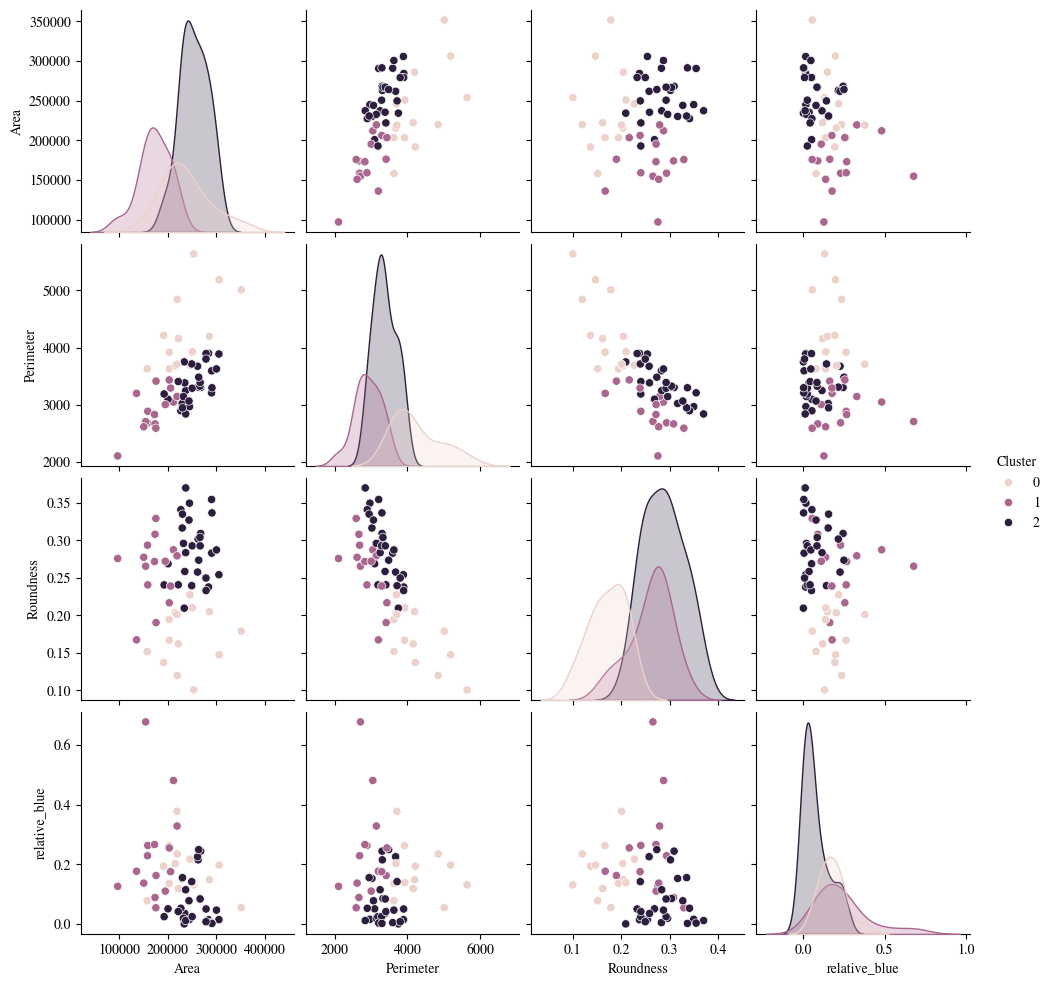

                  Area    Perimeter  Roundness  relative_blue
Cluster                                                      
2        254627.172414  3367.837972   0.287703       0.074782
0        237774.214286  4245.631164   0.171794       0.178174
1        172950.400000  2908.643459   0.260945       0.235618


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
# kmeans to find three groups in the images



# features = features_df[['Area', 'Perimeter', 'Feret', 'Roundness', 'relative_blue']]
features = features_df[['Area', 'Perimeter', 'Roundness', 'relative_blue']]

# features['Feret'] = features['Feret'].apply(lambda x: x[0])
features_df['Perimeter'] = pd.to_numeric(features_df['Perimeter'])
# features_df['Feret'] = pd.to_numeric(features_df['Feret'])
features_df['Roundness'] = pd.to_numeric(features_df['Roundness'])
features_df['RelativeBlue'] = pd.to_numeric(features_df['relative_blue'])


scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
features_df['Cluster'] = kmeans.fit_predict(scaled_features)

features_df['Cluster'] = kmeans.labels_

# df = features_df[['Area', 'Perimeter', 'Feret', 'Roundness', 'relative_blue', 'Cluster']]
df = features_df[['Area', 'Perimeter', 'Roundness', 'relative_blue', 'Cluster']]
# sns.pairplot(df, hue='Cluster', diag_kind='kde', vars=['Area', 'Perimeter', 'Feret', 'Roundness', 'relative_blue'])
sns.pairplot(df, hue='Cluster', diag_kind='kde', vars=['Area', 'Perimeter', 'Roundness', 'relative_blue'])
plt.show()

cluster_summary = df.groupby('Cluster').mean()
cluster_summary = cluster_summary.sort_values(by='relative_blue', ascending=True)
print(cluster_summary)

In [18]:
thresholds = {}
for cluster in range(3):  
    cluster_data = features_df[features_df['Cluster'] == cluster]
    thresholds[cluster] = {}
    # for column in ['Area', 'Perimeter', 'Feret', 'Roundness', 'RelativeBlue']:
    for column in ['Area', 'Perimeter', 'Roundness', 'RelativeBlue']:

        thresholds[cluster][column] = {
            'min': cluster_data[column].min(),
            'max': cluster_data[column].max()
        }
        print(f"Cluster {cluster} - {column} min: {thresholds[cluster][column]['min']}, max: {thresholds[cluster][column]['max']}")


Cluster 0 - Area min: 158130, max: 351637
Cluster 0 - Perimeter min: 3628.0615926535893, max: 5637.71359265359
Cluster 0 - Roundness min: 0.10052127185400413, max: 0.2274170379441088
Cluster 0 - RelativeBlue min: 0.05519031566999491, max: 0.377975525384461
Cluster 1 - Area min: 97357, max: 219557
Cluster 1 - Perimeter min: 2106.1515926535894, max: 3435.03059265359
Cluster 1 - Roundness min: 0.16724033007184902, max: 0.3292172922313514
Cluster 1 - RelativeBlue min: 0.054482392288420764, max: 0.677806736304265
Cluster 2 - Area min: 192987, max: 305692
Cluster 2 - Perimeter min: 2839.91759265359, max: 3899.11659265359
Cluster 2 - Roundness min: 0.20953749205585312, max: 0.3699095694831653
Cluster 2 - RelativeBlue min: 0.0004646528264302224, max: 0.24958853709124093


# 5.4

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

X_shape = features_df.drop(columns=['Image', 'Cluster'])

y = features_df['Cluster']  

X_shape_train, X_shape_test, y_train, y_test = train_test_split(X_shape, y, test_size=0.2, random_state=42)


In [66]:
# SVM on shape features
svm_shape = SVC(kernel='linear', random_state=42)
svm_shape.fit(X_shape_train, y_train)

y_shape_pred = svm_shape.predict(X_shape_test)

print("shape features SVM results:")
print(classification_report(y_test, y_shape_pred))
print(confusion_matrix(y_test, y_shape_pred))


shape features SVM results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         7

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[4 0 0]
 [0 1 0]
 [0 0 7]]


# testing with tensorelements

C:\Users\bramv\AppData\Local\Temp\ipykernel_23776\1311614499.py:6: DeprecationWarning: dip.Image.TensorElement() is deprecated and will be removed in a future version of PyDIP. Use () indexing instead.
  red_channel = img.TensorElement(0)
C:\Users\bramv\AppData\Local\Temp\ipykernel_23776\1311614499.py:7: DeprecationWarning: dip.Image.TensorElement() is deprecated and will be removed in a future version of PyDIP. Use () indexing instead.
  green_channel = img.TensorElement(1)
C:\Users\bramv\AppData\Local\Temp\ipykernel_23776\1311614499.py:8: DeprecationWarning: dip.Image.TensorElement() is deprecated and will be removed in a future version of PyDIP. Use () indexing instead.
  blue_channel = img.TensorElement(2)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


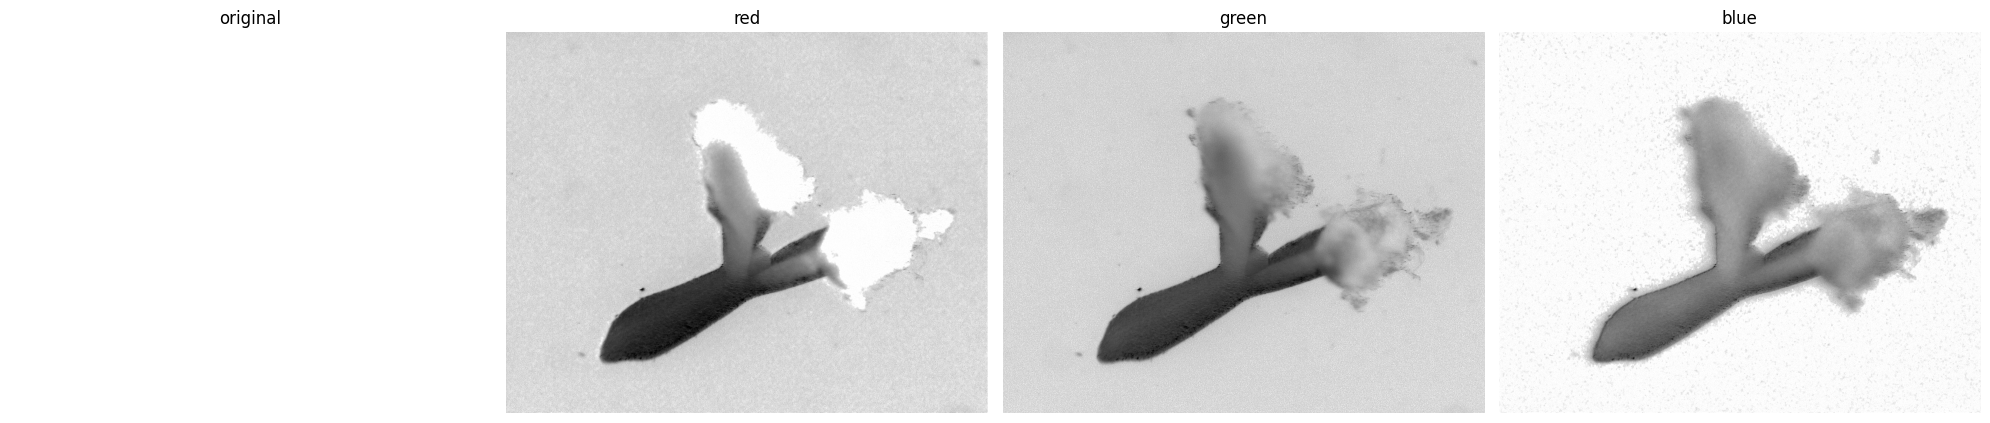

In [ ]:
def plot_image_channels(image_path):
    img = dip.ImageReadTIFF(image_path)
    img = img / 2 ** 16
    img = dip.ColorSpaceManager.Convert(img, 'CMY')

    red_channel = img.TensorElement(0)
    green_channel = img.TensorElement(1)
    blue_channel = img.TensorElement(2)
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    axes[0].imshow(np.array(img), cmap='gray')
    axes[0].set_title('original')
    axes[0].axis('off')
    
    axes[1].imshow(np.array(red_channel), cmap='gray')
    axes[1].set_title('red')
    axes[1].axis('off')
    
    axes[2].imshow(np.array(green_channel), cmap='gray')
    axes[2].set_title('green')
    axes[2].axis('off')
    
    axes[3].imshow(np.array(blue_channel), cmap='gray')
    axes[3].set_title('blue')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()

image_path = 'images/w8t1t2_d7_01.tif'
plot_image_channels(image_path)


C:\Users\bramv\AppData\Local\Temp\ipykernel_23776\2785859745.py:7: DeprecationWarning: dip.Image.TensorElement() is deprecated and will be removed in a future version of PyDIP. Use () indexing instead.
  hue_channel = hsv_img.TensorElement(0)
C:\Users\bramv\AppData\Local\Temp\ipykernel_23776\2785859745.py:8: DeprecationWarning: dip.Image.TensorElement() is deprecated and will be removed in a future version of PyDIP. Use () indexing instead.
  saturation_channel = hsv_img.TensorElement(1)
C:\Users\bramv\AppData\Local\Temp\ipykernel_23776\2785859745.py:9: DeprecationWarning: dip.Image.TensorElement() is deprecated and will be removed in a future version of PyDIP. Use () indexing instead.
  value_channel = hsv_img.TensorElement(2)


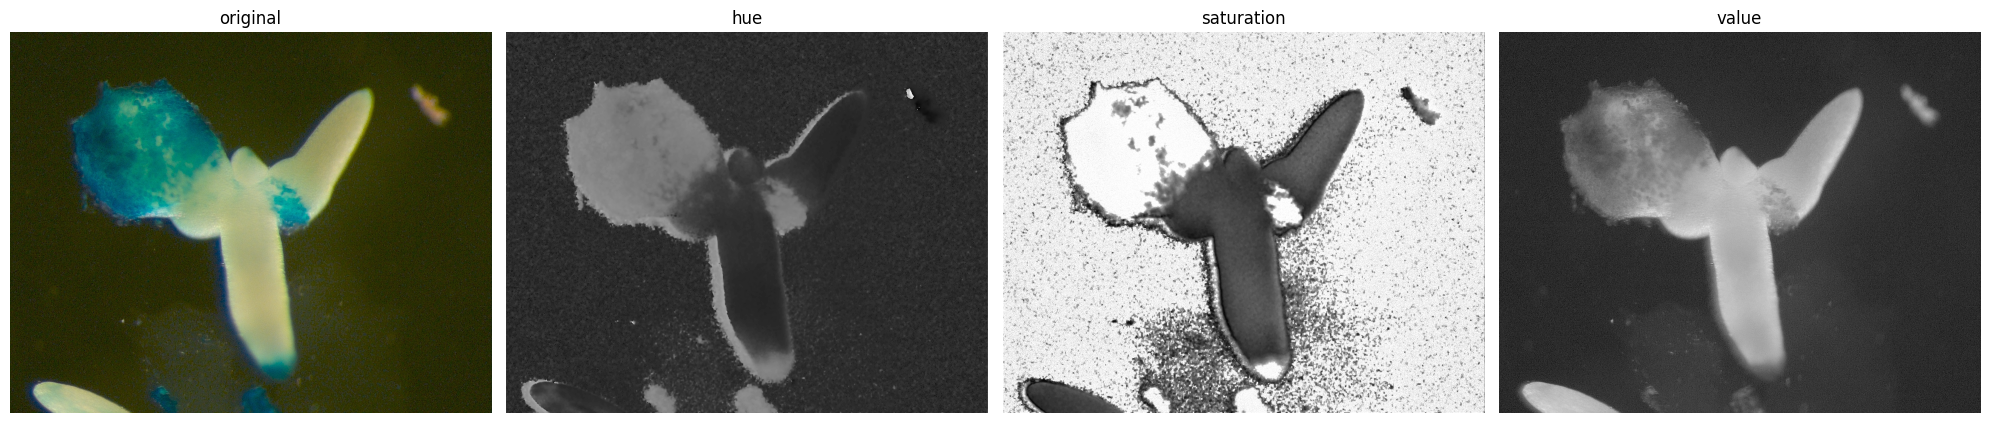

In [ ]:
def plot_image_hsv_channels(image_path):
    img = dip.ImageReadTIFF(image_path)
    img = img / 2 ** 16

    hsv_img = dip.ColorSpaceManager.Convert(img, 'HSV')
    
    hue_channel = hsv_img.TensorElement(0)
    saturation_channel = hsv_img.TensorElement(1)
    value_channel = hsv_img.TensorElement(2)
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    axes[0].imshow(np.array(img), cmap='gray')
    axes[0].set_title('original')
    axes[0].axis('off')
    
    axes[1].imshow(np.array(hue_channel), cmap='gray')
    axes[1].set_title('hue')
    axes[1].axis('off')
    
    axes[2].imshow(np.array(saturation_channel), cmap='gray')
    axes[2].set_title('saturation')
    axes[2].axis('off')
    
    axes[3].imshow(np.array(value_channel), cmap='gray')
    axes[3].set_title('value')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()

image_path = 'images/w8t1t2_d7_02.tif'
plot_image_hsv_channels(image_path)
